# VAE on CelebA dataset with pytorch lightning


In [1]:
!wget -q https://github.com/probml/probml-data/raw/main/checkpoints/vae-celeba-conv.ckpt
!wget -q https://raw.githubusercontent.com/probml/pyprobml/master/vae/standalone/vae_celeba_lightning.py
!wget -q https://raw.githubusercontent.com/probml/pyprobml/master/vae/standalone/lvm_plots_utils.py
!wget -q https://raw.githubusercontent.com/sayantanauddy/vae_lightning/main/data.py
!wget -q https://github.com/probml/probml-data/raw/main/data/celebA_male_img.npy

# Install lightning

In [2]:
%%capture
! pip install -qq torchvision pytorch-lightning torchmetrics  torch test-tube lightning-bolts umap-learn einops

In [3]:
import os
import pandas as pd
from collections import OrderedDict
import matplotlib.pyplot as plt
import numpy as np

try:
    import torch
except ModuleNotFoundError:
    %pip install -qq torch
    import torch
import torch.nn as nn
import torch.nn.functional as F

try:
    import torchvision
except ModuleNotFoundError:
    %pip install -qq torchvision
    import torchvision
import torchvision.transforms as transforms

try:
    from pytorch_lightning import LightningDataModule, LightningModule, Trainer
except ModuleNotFoundError:
    %pip install -qq pytorch_lightning
    from pytorch_lightning import LightningDataModule, LightningModule, Trainer
from torch.utils.data import DataLoader, random_split

try:
    from vae_celeba_lightning import VAE
except ModuleNotFoundError:
    %pip install -qq vae_celeba_lightning
    from vae_celeba_lightning import VAE
try:
    from einops import rearrange
except ModuleNotFoundError:
    %pip install -qq einops
    from einops import rearrange
from torchvision.utils import make_grid

try:
    from tqdm import tqdm
except ModuleNotFoundError:
    %pip install -qq tqdm
    from tqdm import tqdm
try:
    from lvm_plots_utils import get_random_samples, get_grid_samples, plot_scatter_plot, get_imrange, make_imrange
except ModuleNotFoundError:
    %pip install -qq lvm_plots_utils
    from lvm_plots_utils import get_random_samples, get_grid_samples, plot_scatter_plot, get_imrange, make_imrange

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get CelebA data





## Get API key from Kaggle

Follow [these instructions](https://github.com/Kaggle/kaggle-api#api-credentials) to get a kaggle.json key file. Then upload it to colab.


In [5]:
try:
    from google.colab import files
except ModuleNotFoundError:
    %pip install -qq google
    from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [6]:
!mkdir /root/.kaggle
!cp kaggle.json /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json
!rm kaggle.json

## Pytorch dataset and lightning datamodule

This replaces torchvision.datasets.CelebA by downloading from kaggle instead of gdrive.

Code is from https://github.com/sayantanauddy/vae_lightning/blob/main/data.py

In [7]:
try:
    from data import CelebADataset, CelebADataModule
except ModuleNotFoundError:
    %pip install -qq data
    from data import CelebADataset, CelebADataModule

In [ ]:
ds = CelebADataset(root="kaggle", split="test", target_type="attr", download=True)

100%|██████████| 1.33G/1.33G [00:28<00:00, 49.6MB/s]

In [ ]:
IMAGE_SIZE = 64
BATCH_SIZE = 512
CROP = 128
DATA_PATH = "kaggle"

trans = []
trans.append(transforms.RandomHorizontalFlip())
if CROP > 0:
    trans.append(transforms.CenterCrop(CROP))
trans.append(transforms.Resize(IMAGE_SIZE))
trans.append(transforms.ToTensor())
transform = transforms.Compose(trans)

dm = CelebADataModule(
    data_dir=DATA_PATH,
    target_type="attr",
    train_transform=transform,
    val_transform=transform,
    download=True,
    batch_size=BATCH_SIZE,
    num_workers=1,
)

In [ ]:
dm.prepare_data()  # force download now
dm.setup()  # force make data loaders no
batch = next(iter(dm.train_dataloader()))  # take the first batch

# VAE

In [ ]:
m = VAE(input_height=IMAGE_SIZE)
m.load_state_dict(torch.load("vae-celeba-conv.ckpt"))
m.to(device)

VAE(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (4): Sequentia

## Reconstruction

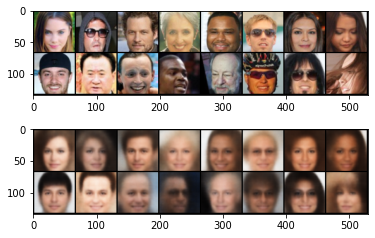

In [ ]:
imgs, _ = batch
imgs = imgs[:16]

fig, axs = plt.subplots(2, 1)
axs[0].imshow(rearrange(make_grid(imgs), "c h w -> h w c"))
imgs = imgs.to(device=device)
axs[1].imshow(rearrange(make_grid(m(imgs).cpu().detach()), "c h w -> h w c"))
plt.show()

## Random Sample From TN[0,1]

In [ ]:
def decoder(z):
    return m.decode(z)

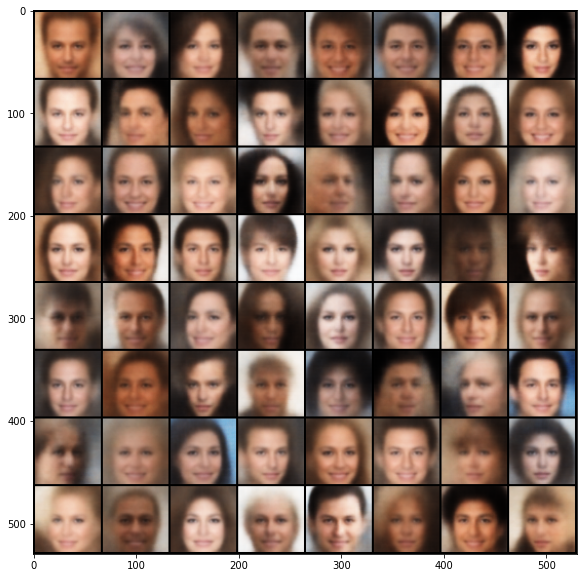

In [ ]:
plt.figure(figsize=(10, 10))
# Where 5 is the truncation threshold for our truncated normal distribution we are sampling from
imgs = get_random_samples(decoder, 5, m.latent_dim)
plt.imshow(imgs)

## Vector Arithmetic

In [ ]:
imgs, attr = batch
df = pd.DataFrame(
    attr.numpy(),
    columns=[
        "5_o_Clock_Shadow",
        "Arched_Eyebrows",
        "Attractive",
        "Bags_Under_Eyes",
        "Bald",
        "Bangs",
        "Big_Lips",
        "Big_Nose",
        "Black_Hair",
        "Blond_Hair",
        "Blurry",
        "Brown_Hair",
        "Bushy_Eyebrows",
        "Chubby",
        "Double_Chin",
        "Eyeglasses",
        "Goatee",
        "Gray_Hair",
        "Heavy_Makeup",
        "High_Cheekbones",
        "Male",
        "Mouth_Slightly_Open",
        "Mustache",
        "Narrow_Eyes",
        "No_Beard",
        "Oval_Face",
        "Pale_Skin",
        "Pointy_Nose",
        "Receding_Hairline",
        "Rosy_Cheeks",
        "Sideburns",
        "Smiling",
        "Straight_Hair",
        "Wavy_Hair",
        "Wearing_Earrings",
        "Wearing_Hat",
        "Wearing_Lipstick",
        "Wearing_Necklace",
        "Wearing_Necktie",
        "Young",
    ],
)


def encoder(img):
    return m.encode(img)[0]


def vector_of_interest(feature_of_interest="Male"):
    id = np.array(df.index)
    get_id_of_all_absent = id[df[feature_of_interest] == 0]
    get_id_of_all_present = id[df[feature_of_interest] == 1]
    present = (imgs[get_id_of_all_present]).to(device)
    absent = (imgs[get_id_of_all_absent]).to(device)
    z_present = encoder(present).mean(axis=0)
    z_absent = encoder(absent).mean(axis=0)
    label_vector = z_present - z_absent
    return label_vector, present, absent

In [ ]:
feature_of_interest = "Eyeglasses"
vec1, glasses, no_glasses = vector_of_interest(feature_of_interest)

feature_of_interest = "Smiling"
vec2, similing, not_similing = vector_of_interest(feature_of_interest)

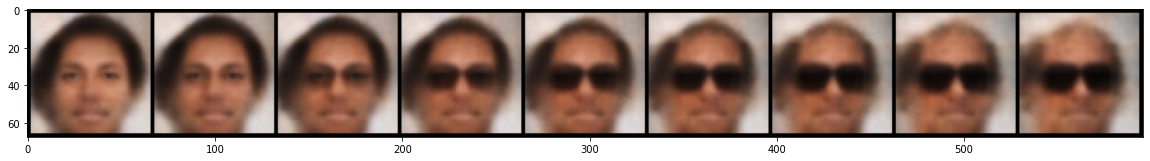

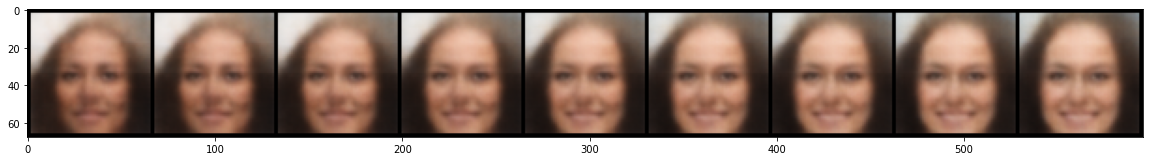

In [ ]:
def encoder(img):
    return m.encode(img)[0]


def decoder(z):
    return m.decode(z)[0]


img1 = torch.reshape(glasses[1], [1, 3, 64, 64])
img2 = torch.reshape(similing[1], [1, 3, 64, 64])
for img, vec in zip([img1, img2], [vec1, vec2]):
    z = encoder(img)
    arr = []
    for k in range(-4, 5):
        imgk = decoder(z + k * vec)
        arr.append(imgk)
    arr2 = make_imrange(arr)
    plt.figure(figsize=(20, 10))
    plt.imshow(arr2)

## Interpolation

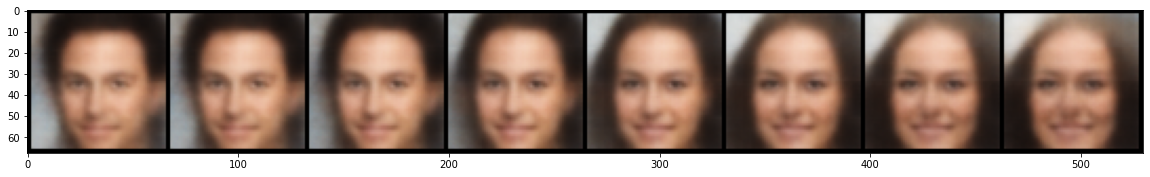

In [ ]:
feature_of_interest = "Male"
vec3, male, female = vector_of_interest(feature_of_interest)

start_img = torch.reshape(male[1], [1, 3, 64, 64])
end_img = torch.reshape(female[1], [1, 3, 64, 64])
plt.figure(figsize=(20, 10))
arr = get_imrange(decoder, encoder(start_img), encoder(end_img), nums=8, interpolation="linear")
plt.imshow(arr)

## 2D Color embedding of latent space

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


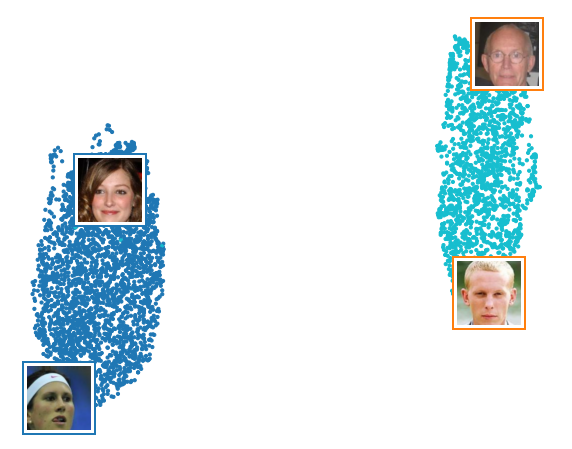

In [ ]:
batch = (imgs, df[feature_of_interest])
plot_scatter_plot(batch, encoder, use_embedder="UMAP")